# Spherical Cap

In [339]:
import numpy as np
import pandas as pd
# import rpy2.rinterface

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.datasets import (make_swiss_roll, make_s_curve)
from sklearn import datasets

In [340]:
from megaman.datasets import generate_megaman_manifold
from megaman.geometry import Geometry
from megaman.embedding import (Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding)
from megaman.plotter import (plot_with_plotly, plot_embedding_with_plotly, 
                     plot_with_matplotlib, plot_embedding_with_matplotlib) 
from megaman.geometry.rmetric import RiemannMetric
from megaman.utils.covar_plotter import plot_cov_ellipse

In [341]:
# Geometry
radius = 1.0
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/radius^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

Text(0.5, 0.92, 'Example of a uniformly sampled sphere')

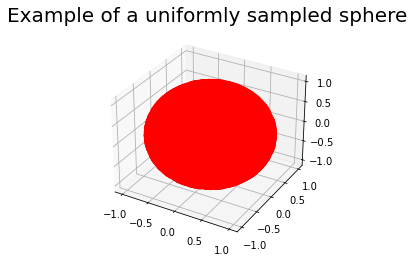

In [342]:
# Data
import random
random.seed(1)
x = []
y = []
z = []
N = 5000
for i in range(N):
    u = np.random.normal(0,1)
    v = np.random.normal(0,1)
    w = np.random.normal(0,1)
    norm = (u*u + v*v + w*w)**(0.5)
    xi,yi,zi = u/norm,v/norm,w/norm
    x.append(xi)
    y.append(yi)
    z.append(zi)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
#ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(x, y, z, s=100, c='r', zorder=10)
ax.set_title('Example of a uniformly sampled sphere', fontdict={'fontsize':20})

In [343]:
df = pd.DataFrame({'x':x, 'y':y, 'z':z})
print(df)

             x         y         z
0    -0.724122  0.535596  0.434493
1     0.439552 -0.569864 -0.694298
2    -0.273758  0.935125  0.224941
3     0.525042 -0.663778  0.532664
4     0.266203 -0.961072 -0.074003
...        ...       ...       ...
4995  0.474233  0.702023 -0.531287
4996 -0.505458  0.840122 -0.196741
4997  0.261019  0.958995 -0.110447
4998 -0.962973 -0.115975  0.243377
4999  0.037639 -0.199987  0.979075

[5000 rows x 3 columns]


In [344]:
theta = np.arccos(z)
phi = np.arctan(np.divide(y, x))
phi[df[(df["x"]<0)&(df["y"]<0)].index] -= np.pi
phi[df[(df["x"]<0)&(df["y"]>=0)].index] += np.pi
# phi_series = pd.Series(phi, index=df.index)
# phi_series.loc[df[(df["x"]<0)&(df["y"]<0)].index] -= np.pi

In [345]:
min(phi)

-3.1413551560821116

In [346]:
# # Load data generated from R
# import feather
# import os

# os.getcwd()
# os.chdir(path="/Users/fche0019/git/kderm/")
# read the feather data frames
# df = feather.read_dataframe("python/sphericalcap_x.feather")
# y = feather.read_dataframe("python/sphericalcap_y.feather")
# ycap = feather.read_dataframe("python/sphericalcap_ycap.feather")

In [347]:
theta0 = 1.5
y = pd.DataFrame({"y1": theta * np.cos(phi), "y2": theta * np.sin(phi)})
theta = pd.Series(theta)
ycap = y.loc[theta[theta < theta0].index]
# np.array(ycap)

In [348]:
# caparea / areaball_local
2 * (1 - np.cos(theta0)) / (theta0**2)

0.8260113762953751

# Geometry

In [349]:
# Initialize Geometry class
radius = 1
adjacency_method = 'kd_tree'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/bandwidth^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

In [350]:
geom.set_data_matrix(df)

In [411]:
# Radius selection
from scipy.sparse.csgraph import connected_components

rad1 = 1 # choose a small searching radius to start, but result in a fully connected graph
bandwidth = .4 # bandwidth in the weight matrix and the Laplacian matrix
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius': bandwidth}
affinity_matrix = geom.compute_affinity_matrix({'radius':bandwidth})
# compute the Laplacian matrix
geom.laplacian_method = 'geometric'
geom.laplacian_kwds = {'scaling_epps':bandwidth} # scaling ensures convergence to Laplace-Beltrami operator
laplacian_matrix = geom.compute_laplacian_matrix()

(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components) # 1 means fully connected graph

1


In [412]:
adjacency_matrix.todense()

matrix([[0.        , 0.        , 0.63746613, ..., 0.        , 0.71980526,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.63746613, 0.        , 0.        , ..., 0.6316968 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.6316968 , ..., 0.        , 0.        ,
         0.        ],
        [0.71980526, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [413]:
laplacian_matrix.todense()

matrix([[-2.48791937e+01,  0.00000000e+00,  9.43516953e-03, ...,
          0.00000000e+00,  4.47003882e-03,  0.00000000e+00],
        [ 0.00000000e+00, -2.48733054e+01,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.28328099e-03,  0.00000000e+00, -2.48834863e+01, ...,
          1.14712239e-02,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.02928418e-02, ...,
         -2.48513950e+01,  0.00000000e+00,  0.00000000e+00],
        [ 4.56475850e-03,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -2.48902649e+01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00, -2.48672298e+01]])

In [414]:
# Estimate Riemannian metric for all four methods
# from megaman.geometry.rmetric import RiemannMetric
rmetric = RiemannMetric(np.array(y), geom.laplacian_matrix)
H = rmetric.get_rmetric()
H_dual = rmetric.get_dual_rmetric() # inverse of H matrix

In [415]:
print(H[:3, :]) # N*2*2 array

[[[ 0.88047702 -0.17946675]
  [-0.17946675  0.7362322 ]]

 [[ 0.18656529 -0.12336618]
  [-0.12336618  0.26171433]]

 [[ 0.57879013 -0.10829529]
  [-0.10829529  0.946366  ]]]


In [416]:
print(H_dual[:3, :]) # N*2*2 array

[[[1.19512933 0.29132926]
  [0.29132926 1.42928267]]

 [[7.78735682 3.67078291]
  [3.67078291 5.55128365]]

 [[1.76554422 0.20203612]
  [0.20203612 1.07979319]]]


In [417]:
# H_inverse = np.linalg.inv(H)
# print(H_inverse[:3, :])
# np.array_equal(H_inverse, H_dual)

In [418]:
theta0 = 2.5
# caparea / areaball_local
2 * (1 - np.cos(theta0)) / (theta0**2)
# theta = pd.Series(theta)
# ycap = y.loc[theta[theta < theta0].index]

0.5763659569750188

In [419]:
np.mean(np.sqrt(np.linalg.det(H[theta[theta < theta0].index])))

0.6261838371504151

In [420]:
np.mean(np.sqrt(np.linalg.det(H_dual[theta[theta < theta0].index])))

2.1255898083940754

In [421]:
# Embedding
# select output dimension
n_components = 2
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(df)

In [422]:
print(embed_isomap)

[[ 1.16551478 -0.55967794]
 [-0.89864348  0.95935457]
 [ 0.89844563 -0.55456644]
 ...
 [ 0.29325589 -0.27984267]
 [ 1.02350618 -0.03296741]
 [-0.14436668 -1.15689673]]
